In [198]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import acf

from statsmodels.tsa.seasonal import STL

### 1.0. PBS

Load Data and simple descriptive stats. (Tidy)

In [199]:
df = pd.read_csv("../data/PBS.csv", index_col=[0])

df["Month"] = pd.to_datetime(df["Month"], format="%Y %b")

In [200]:
df.head()

,Month,Concession,Type,ATC1,ATC1_desc,ATC2,ATC2_desc,Scripts,Cost
1,1991-07-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,18228,67877.0
2,1991-08-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15327,57011.0
3,1991-09-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14775,55020.0
4,1991-10-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15380,57222.0
5,1991-11-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14371,52120.0


In [201]:
df.select_dtypes(include=["object"]).describe().T

,count,unique,top,freq
Concession,67596,2,Concessional,34020
Type,67596,2,Safety net,33984
ATC1,67596,15,A,10140
ATC1_desc,64403,14,Alimentary tract and metabolism,10058
ATC2,67596,84,A01,816
ATC2_desc,65219,84,STOMATOLOGICAL PREPARATIONS,816


In [202]:
df.select_dtypes(exclude=["object", "datetime64[ns]"]).describe().T

,count,mean,std,min,25%,50%,75%,max
Scripts,67596.0,35096.171534,1.068033e+05,0.0,68.000,1225.500,13506.7500,1607119.0
Cost,67596.0,868677.623408,2.987325e+06,0.0,1743.935,33396.575,348131.2825,72911261.0


In [203]:
df["ATC1_desc"].value_counts()

ATC1_desc
Alimentary tract and metabolism                                    10058
Dermatologicals                                                     7454
Cardiovascular system                                               7028
Nervous system                                                      4896
Antiinfectives for systemic use                                     4608
Various                                                             4076
Systemic hormonal preparations, excl. sex hormones and insulins     4063
Musculo-skeletal system                                             3836
Respiratory system                                                  3495
Blood and blood forming organs                                      3264
Antineoplastic and immunomodulating agents                          3216
Genito urinary system and sex hormones                              3007
Sensory organs                                                      2991
Antiparasitic products, insecticides and 

In [204]:
df["ATC1"].value_counts()

ATC1
A    10140
D     8100
C     7344
N     4896
J     4848
H     4080
M     4080
V     4080
R     3936
B     3264
G     3264
L     3216
S     3120
P     2412
Z      816
Name: count, dtype: int64

In [205]:
df_stats = df.iloc[:, 1:].groupby(["Concession", "Type", "ATC1", "ATC2"]).agg(
    min=("Cost", "min"),
    std=("Cost", "std"),
    p25=("Cost", lambda x: x.quantile(0.25)),
    median=("Cost", "median"),
    mean=("Cost", "mean"),
    p75=("Cost", lambda x: x.quantile(0.75)),
    max=("Cost", "max"),
).reset_index()

In [206]:
df_sort_mean = df_stats.sort_values(by="mean").reset_index(drop=100)

high_mean_dict_mean = df_sort_mean.iloc[-1, :4].to_dict()

lower_std_dict_mean = df_sort_mean[df_sort_mean["std"] > 0].reset_index(drop=True).sort_values(by="std").iloc[0, :4].to_dict()

df_sort_mean

,Concession,Type,ATC1,ATC2,min,std,p25,median,mean,p75,max
0,General,Co-payments,R,R,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00
1,General,Co-payments,S,S,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00
2,General,Co-payments,M,M02,0.00,1.092950e+00,0.000000e+00,0.000000e+00,3.782843e-01,0.000000e+00,7.00
3,General,Co-payments,S,S03,0.00,3.239426e+00,0.000000e+00,0.000000e+00,7.962745e-01,1.000000e+00,36.10
4,General,Safety net,R,R,0.00,5.551202e+00,0.000000e+00,0.000000e+00,1.357696e+00,0.000000e+00,42.15
...,...,...,...,...,...,...,...,...,...,...,...
331,Concessional,Co-payments,N,N06,778948.00,6.635907e+06,5.643519e+06,1.060602e+07,1.093886e+07,1.618561e+07,24832003.00
332,Concessional,Co-payments,R,R03,3475001.00,4.802822e+06,8.507342e+06,1.118818e+07,1.194594e+07,1.517293e+07,23528163.00
333,Concessional,Co-payments,C,C09,4252909.00,7.038693e+06,1.050737e+07,1.487647e+07,1.586914e+07,2.080370e+07,32822780.00
334,Concessional,Co-payments,A,A02,3374112.00,7.498596e+06,1.100026e+07,1.557431e+07,1.645504e+07,2.101970e+07,34146689.00


In [207]:
df_stats = df.iloc[:, 1:].groupby(["Concession", "Type", "ATC1", "ATC2"]).agg(
    m_diff=("Cost", lambda x: np.mean(x.diff())),
    m_shift=("Cost", lambda x: np.mean(x.shift(12))),

    acf1=("Cost", lambda x: acf(x, nlags=1)[-1]),
    acf10=("Cost", lambda x: np.sum(acf(x, nlags=10)[1:] ** 2)),

    diff1_acf1=("Cost", lambda x: acf(x.diff().dropna(), nlags=1)[-1]),
    diff1_acf10=("Cost", lambda x: np.sum(acf(x.diff().dropna(), nlags=10)[1:] ** 2)),
    
    diff2_acf1=("Cost", lambda x: acf(x.diff().dropna().diff().dropna(), nlags=1)[-1]),
    diff2_acf10=("Cost", lambda x: np.sum(acf(x.diff().dropna().diff().dropna(), nlags=10)[1:] ** 2)),

    season_lag=("Cost", lambda x: acf(x, nlags=4)[1:][-1])
).reset_index()

/home/grc/arep/time_series/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:691: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


In [208]:
df_stats = df_stats.sort_values(by="acf10").reset_index(drop=True)

df_stats.dropna(inplace=True)

high_acf = df_stats.iloc[-10:, :4]
lower_acf = df_stats.iloc[:10, :4]

df_stats

,Concession,Type,ATC1,ATC2,m_diff,m_shift,acf1,acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,season_lag
0,General,Co-payments,C,C05,0.000000,4.633958e+00,-0.004971,0.000152,-0.500000,0.250000,-0.666667,0.472222,-0.005044
1,General,Safety net,J,J06,0.000000,2.315385e+00,-0.006024,0.000225,-0.500000,0.250000,-0.666667,0.472222,-0.006131
2,General,Co-payments,S,S02,0.039409,1.334635e+00,0.024225,0.003019,-0.501630,0.255621,-0.675332,0.499238,0.032347
3,Concessional,Safety net,J,J06,0.000000,3.956389e+00,-0.021370,0.003724,-0.500000,0.250000,-0.666667,0.472222,-0.021703
4,General,Co-payments,S,S03,-0.004926,8.460417e-01,0.016161,0.007112,-0.507508,0.259666,-0.670797,0.483060,0.022577
...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,Concessional,Co-payments,B,B02,173.187192,1.679154e+04,0.976009,8.398862,-0.309668,0.197420,-0.613900,0.482602,0.921242
330,Concessional,Co-payments,R,R06,-399.581281,5.371165e+04,0.977767,8.504610,-0.103304,0.126501,-0.479455,0.399159,0.936159
331,General,Co-payments,M,M05,3466.822660,3.894207e+05,0.981541,8.505589,-0.147928,0.255711,-0.638020,0.625320,0.924734
332,General,Co-payments,L,L03,20744.942408,1.920226e+06,0.980483,8.596936,-0.518251,0.414614,-0.740469,0.784816,0.939892


Filter Columns

In [209]:
df = df[["Month", "Concession", "Type", "ATC1", "ATC2", "Cost"]]

In [210]:
df[(df["Month"] == "1991-07-01") & (df["ATC2"] == "A01")]

,Month,Concession,Type,ATC1,ATC2,Cost
1,1991-07-01,Concessional,Co-payments,A,A01,67877.0
17017,1991-07-01,Concessional,Safety net,A,A01,24695.0
34021,1991-07-01,General,Co-payments,A,A01,254.0
50617,1991-07-01,General,Safety net,A,A01,1525.0


Time Series Plots (Visualize)

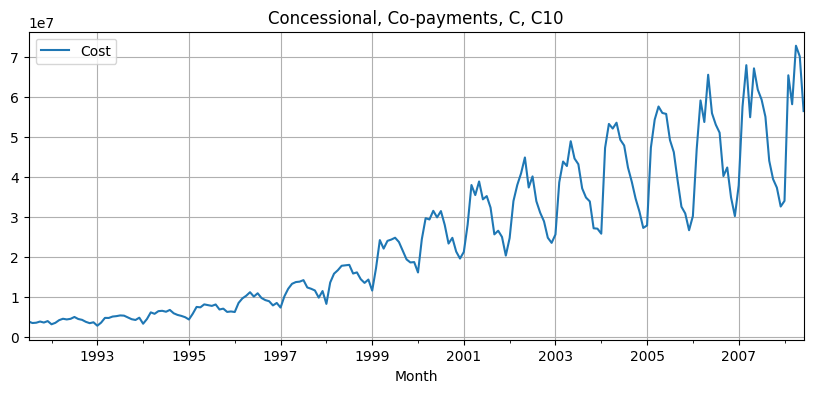

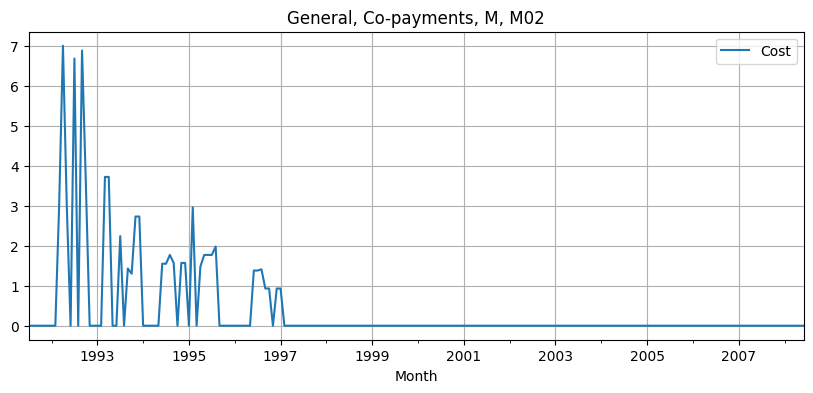

In [211]:
dfa = df[(df["Concession"] == high_mean_dict_mean["Concession"]) &
         (df["Type"] == high_mean_dict_mean["Type"]) &
         (df["ATC1"] == high_mean_dict_mean["ATC1"]) &
         (df["ATC2"] == high_mean_dict_mean["ATC2"])]

dfa.plot(x="Month", y="Cost", figsize=(10, 4), grid=2, title=", ".join(high_mean_dict_mean.values()));

dfa = df[(df["Concession"] == lower_std_dict_mean["Concession"]) &
         (df["Type"] == lower_std_dict_mean["Type"]) &
         (df["ATC1"] == lower_std_dict_mean["ATC1"]) &
         (df["ATC2"] == lower_std_dict_mean["ATC2"])]

dfa.plot(x="Month", y="Cost", figsize=(10, 4), grid=2, title=", ".join(lower_std_dict_mean.values()));

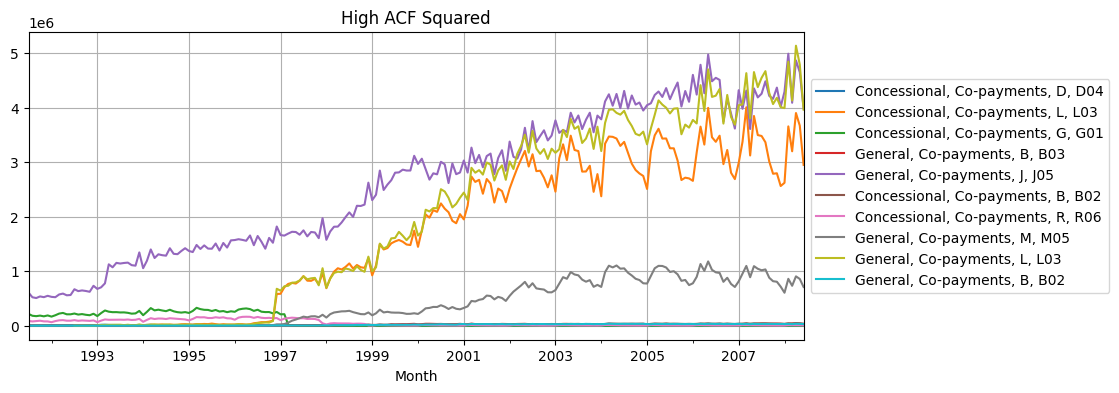

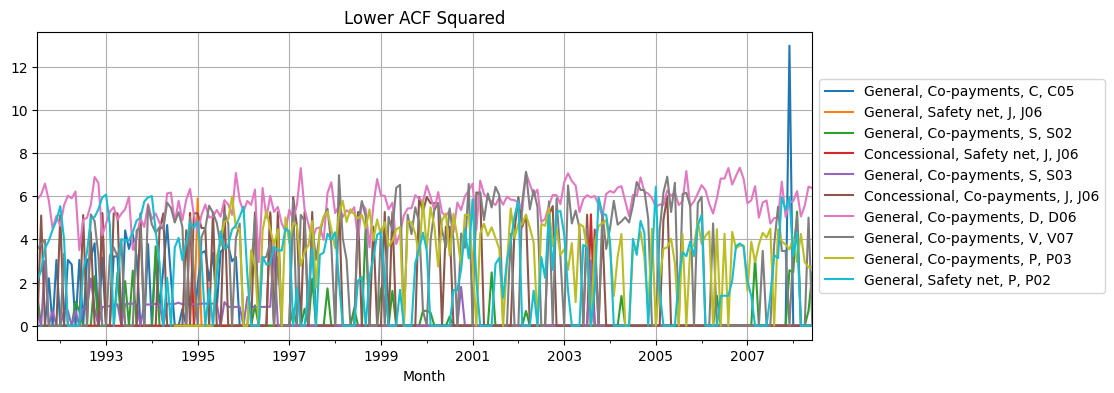

In [212]:
fig, ax = plt.subplots(figsize=(10, 4))

for i, row in high_acf.iterrows():
    dfa = df[(df["Concession"] == row["Concession"]) &
             (df["Type"] == row["Type"]) &
             (df["ATC1"] == row["ATC1"]) &
             (df["ATC2"] == row["ATC2"])]
    
    dfa.plot(x="Month", y="Cost", label=", ".join(row.to_dict().values()), ax=ax)

ax.set_title("High ACF Squared")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.grid(2)

fig, ax = plt.subplots(figsize=(10, 4))
for i, row in lower_acf.iterrows():
    dfa = df[(df["Concession"] == row["Concession"]) &
             (df["Type"] == row["Type"]) &
             (df["ATC1"] == row["ATC1"]) &
             (df["ATC2"] == row["ATC2"])].copy()
    
    dfa.reset_index(drop=2, inplace=True)

    dfa["Cost"] = np.log1p(dfa["Cost"])
    dfa.plot(x="Month", y="Cost", label=", ".join(row.to_dict().values()), ax=ax)

ax.set_title("Lower ACF Squared")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.grid(2)

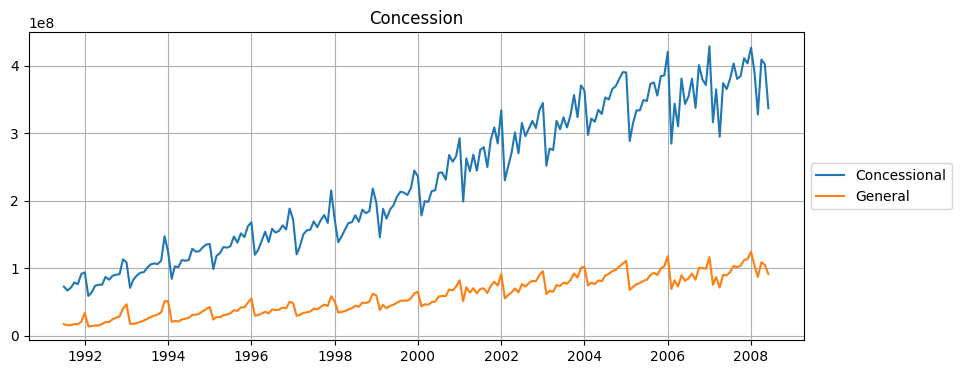

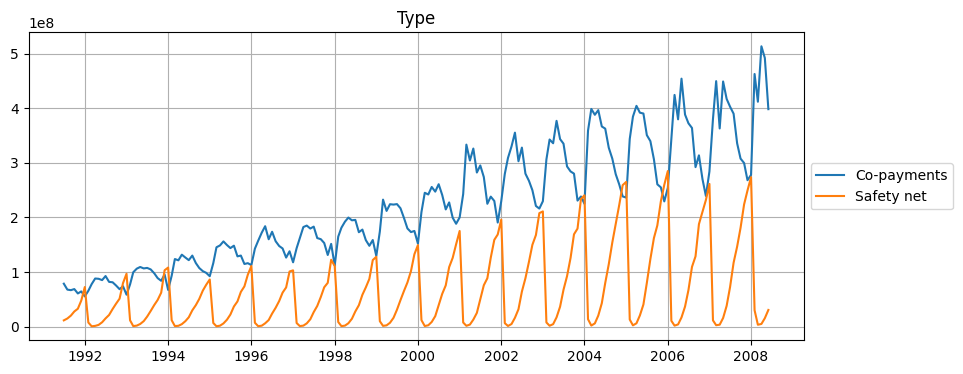

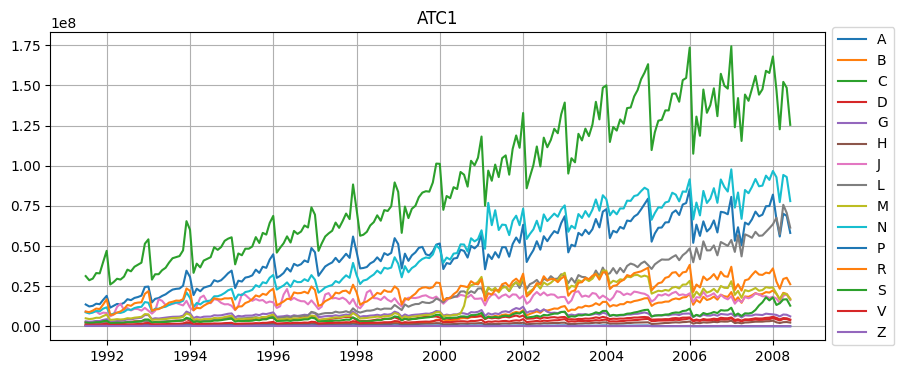

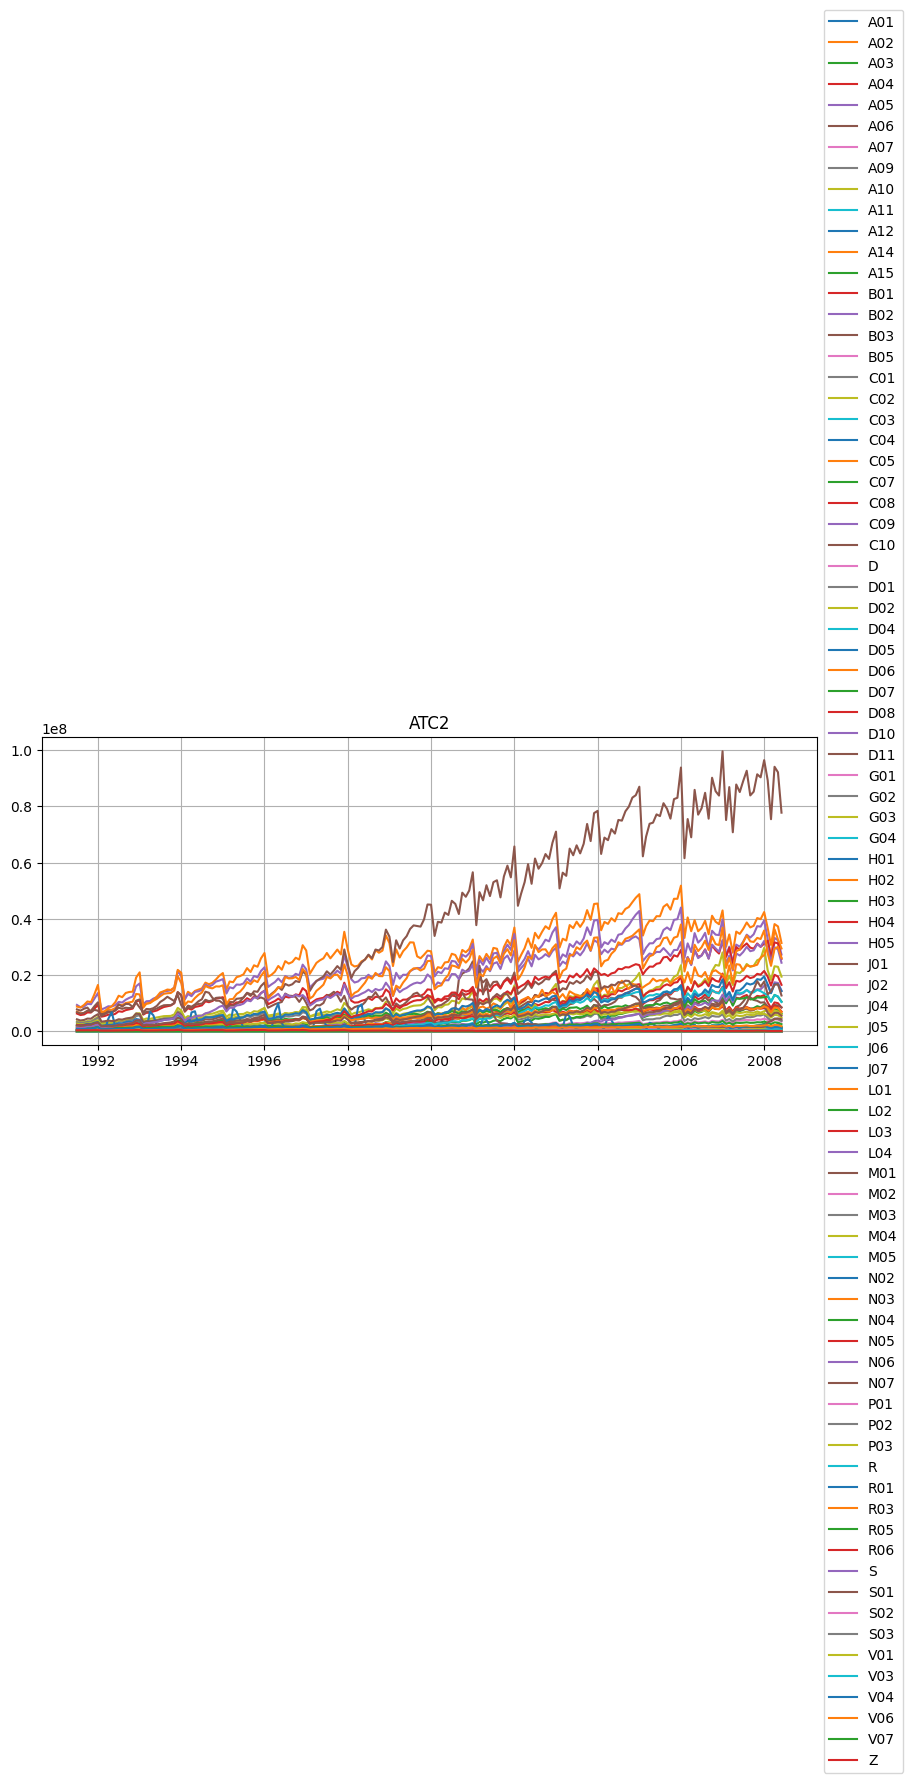

In [81]:
for col in ["Concession", "Type", "ATC1", "ATC2"]:
    fig, ax = plt.subplots(figsize=(10, 4))

    for var in df[col].unique():
        dfa = df[df[col] == var]
        dfa = dfa[["Month", "Cost"]].groupby("Month").sum()
        ax.plot(dfa["Cost"], label=var)

    ax.legend()
    ax.set_title(col)
    ax.legend(loc="center left", bbox_to_anchor=(1, .5))
    ax.grid(2)

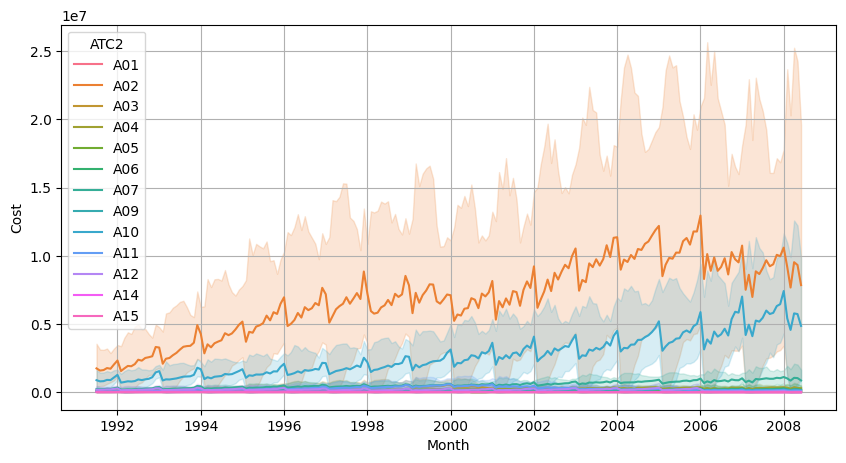

In [143]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(df[df["ATC1"] == "A"], x="Month", y="Cost", hue="ATC2", ax=ax)
ax.grid(2)